In [1]:
IMAGE_SIZE  = 256

NUM_CLASSES = 4

N_EPOCH  = 300

AUX_TASK = False
MOBILE   = False
CAM_POS  = "bot" #top or bot

net_id  = 'robtraymix'   #ID for the model
folder  = 'weights/sigmoid2'  #Model Folder

In [2]:
# imports
import os, time, math
import numpy as np
from scipy import stats
from math import sin, cos, tan
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf

from tensorflow import keras
from keras import layers, Model

from pathlib import Path

In [3]:
# System Info and Config

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
#0 = all messages are logged (default behavior)
#1 = INFO messages are not printed
#2 = INFO and WARNING messages are not printed
#3 = INFO, WARNING, and ERROR messages are not printed

#GPU id to use
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

print("tf.__version__ is", tf.__version__)
print("tf.keras.__version__ is:", tf.keras.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.gpu_device_name())

tf.keras.utils.disable_interactive_logging

#color for mask viz
colormap = np.asarray([[100,  0,  0], [ 0,  0, 100], [ 0, 100,  0], [100,  0, 100], [100, 100, 0]])

if AUX_TASK:
    aux = "res_aux_true"
    if MOBILE:
        aux = "mob_aux_true"
else:
    aux = "res_aux_false"
    if MOBILE:
        aux = "mob_aux_false"


print('input name:',str(IMAGE_SIZE)+'px_'+str(CAM_POS)+'_'+str(aux)+'_'+str(N_EPOCH)+'ep_'+str(net_id)+'.hdf5')

tf.__version__ is 2.12.0
tf.keras.__version__ is: 2.12.0
Num GPUs Available:  0

input name: 256px_bot_res_aux_false_300ep_robtraymix.hdf5


In [4]:
# Function to draw a line on an image (cv2.line() drop-in replacement)
def drawline(img, p1, p2, color):
    w, h = img.shape[0:2]
    
    # Extract x and y coordinates from the input points
    x_values = np.array([p1[1], p2[1]])
    y_values = np.array([p1[0], p2[0]])

    # Use linear regression to get the points of the line
    regr = LinearRegression()
    regr.fit(x_values.reshape(-1, 1), y_values.reshape(-1, 1))

    x_line = np.arange(w).reshape(-1, 1)
    y_line = np.asarray(regr.predict(x_line), np.int16)

    # Draw the line
    for i in range(len(x_line)):
        if y_line[i][0] + 2 > h - 2:
            break
        if y_line[i][0] + 2 > 0:
            img[x_line[i][0]][y_line[i][0]] = np.asarray(color)
            img[x_line[i][0]][y_line[i][0] + 1] = np.asarray(color)
            img[x_line[i][0]][y_line[i][0] - 1] = np.asarray(color)
            img[x_line[i][0]][y_line[i][0] + 2] = np.asarray([0,0,0])
            img[x_line[i][0]][y_line[i][0] - 2] = np.asarray([0,0,0])

    return img

In [5]:
# Function to blend two images (cv2.addWeighted() drop-in replacement)
def addimages(img1, alpha, img2, beta):
    
    result = np.asarray(img1 * alpha + img2 * beta, dtype=np.uint8)

    return np.clip(result,0,255)

In [6]:
# Function to decode the categorical segmentation masks to RGB colors
def decode_segmentation_masks(mask, colormap, n_classes):
    shape = (IMAGE_SIZE,IMAGE_SIZE)
    r = np.empty(shape,dtype=np.uint8)
    g = np.empty(shape,dtype=np.uint8)
    b = np.empty(shape,dtype=np.uint8)
        
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
        
    rgb = np.stack([r, g, b], axis=2)
    return rgb

In [7]:
# Function read the image and X0/X1 from path
def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
    else:
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = image / 127.5 - 1
    return image

def read_X0(line_path):
    flabel = open(line_path, 'r')

    for lines in flabel.readlines():
        label = lines.rstrip().split(',') #mudado para espaço por causa do morango
        if len(label)<2:
            label = lines.rstrip().split(' ')

    x0 = eval(label[0])
    
    x0 = 1 / (1 + np.exp(-(x0 - 320) / 230))

    return x0

def read_X1(line_path):
    flabel = open(line_path, 'r')

    for lines in flabel.readlines():
        label = lines.rstrip().split(',') #mudado para espaço por causa do morango
        if len(label)<2:
            label = lines.rstrip().split(' ')
    
    x1 = eval(label[1])
    
    flabel.close()

    #if x1 < 0:
    #    x1 = (x1+640)/6400
    #elif x1 > 640:
    #    x1 = (x1-640)/6400 + 0.9
    #else:
    #    x1 = (x1)/800 + 0.1
    x1 = 1 / (1 + np.exp(-(x1 - 320) / 230))

    return x1

In [8]:
# Functions to get the file list from the folder
def loadpath_img(my_path):
    files = []
    for path in Path(my_path).rglob('*.jpg'):
        files.append(str(path))
    files.sort()
    return files

def loadpath_msk(my_path):
    files = []
    for path in Path(my_path).rglob('*_cat.png'):
        files.append(str(path))
    files.sort()
    return files

def loadpath_lbl(my_path):
    files = []
    for path in Path(my_path).rglob('*_lbl.txt'):
        files.append(str(path))
    files.sort()
    return files

In [9]:
# Network Model blocks
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)

def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

def get_x0(x):
    shape = x.shape

    flatten = layers.Flatten(input_shape=shape)(x)
    hidden_layer = layers.Dense(25, activation='relu', use_bias=True)(flatten)
    hidden_layer = layers.Dense(20, activation='relu', use_bias=True)(hidden_layer)
    output_x0 = layers.Dense(1, activation='sigmoid', use_bias=True, name="x0")(hidden_layer)

    return output_x0

def get_x1(x):
    shape = x.shape

    flatten = layers.Flatten(input_shape=shape)(x)
    hidden_layer = layers.Dense(25, activation='relu', use_bias=True)(flatten)
    hidden_layer = layers.Dense(20, activation='relu', use_bias=True)(hidden_layer)
    output_x1 = layers.Dense(1, activation='sigmoid', use_bias=True, name="x1")(hidden_layer)

    return output_x1

In [10]:
# Resnet with aux task (DeeplabV3+)

def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    
    x1_out = get_x1(x)
    x0_out = get_x0(x)

    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)

    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)

    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same", name="mask")(x)

    return keras.Model(inputs=model_input, outputs=[model_output, x0_out, x1_out])

In [11]:
# MobileNet with aux task (DeeplabV3+) (Check if running old version - BRACIS or Thesis)

def DeeplabV3_mobile2(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    MobileNet2 = keras.applications.MobileNetV2(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = MobileNet2.get_layer("block_16_project_BN").output
    #x = MobileNet2.get_layer("block_13_depthwise_relu").output #(Thesis and BRACIS compatibility)

    x1_out = get_x1(x)
    x0_out = get_x0(x)

    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = MobileNet2.get_layer("block_2_add").output 
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    # Determine the desired spatial dimensions
    desired_height = input_b.shape[1]
    desired_width = input_b.shape[2]

    # Calculate the padding to add to input_b
    pad_height = desired_height - input_a.shape[1]
    pad_width = desired_width - input_a.shape[2]

    # Ensure the padding values are non-negative
    pad_height = max(0, pad_height)
    pad_width = max(0, pad_width)

    # Define the padding tensor
    padding = tf.constant([[0, 0], [pad_height // 2, pad_height // 2], [pad_width // 2, pad_width // 2], [0, 0]])

    # Pad input_b
    input_a = tf.pad(input_a, padding, "CONSTANT", constant_values=0)

    # Now, input_b has the same spatial dimensions as input_a
    # You can proceed to concatenate them
    x = layers.Concatenate(axis=-1)([input_a, input_b])

    x = convolution_block(x)
    x = convolution_block(x)

    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)

    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same", name="mask")(x)
    return keras.Model(inputs=model_input, outputs=[model_output, x0_out, x1_out])

In [12]:
# Resnet without aux task

def resnet_model_no_aux(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    
    x1_out = get_x1(x)
    x0_out = get_x0(x)

    return keras.Model(inputs=model_input, outputs=[ x0_out, x1_out])

In [13]:
# MobileNet without aux task

def mobile_model_no_aux(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    MobileNet2 = keras.applications.MobileNetV2(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = MobileNet2.get_layer("block_16_project_BN").output #block_13_depthwise_relu

    x1_out = get_x1(x)
    x0_out = get_x0(x)

    return keras.Model(inputs=model_input, outputs=[ x0_out, x1_out])

In [14]:
# Model Construction
if AUX_TASK:
    if MOBILE:
        model = DeeplabV3_mobile2(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)

    else:
        model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
    
else:
    if MOBILE:
        model = mobile_model_no_aux(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
    else:
        model = resnet_model_no_aux(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)

print(str(aux)+' model created')

res_aux_false model created


In [15]:
#MULTI-Roi
#UDACITY
def exg(im_to_binarize):
    im_to_binarize = im_to_binarize.astype(np.float32)      #np.float deprecated -> np.float32 (mar/2023)
    R_ = im_to_binarize[:,:,2]/np.max(im_to_binarize[:,:,2])
    G_ = im_to_binarize[:,:,1]/np.max(im_to_binarize[:,:,1])
    B_ = im_to_binarize[:,:,0]/np.max(im_to_binarize[:,:,0])
    
    r = R_/(R_+G_+B_+0.00001)
    g = G_/(R_+G_+B_+0.00001)
    b = B_/(R_+G_+B_+0.00001)
    
    excess_red = 1.4*r - g
    excess_green = 2*g - r - b
    return excess_green
def exg_th(img, th = [0.1, 0.3], *args):
    a = exg(img)
    b = np.zeros(shape = a.shape)
    b[a<th[0]] = 0
    b[(a>=th[0]) & (a < th[1])] = (a[(a>=th[0]) & (a < th[1])] - th[0])/(th[1] - th[0])
    b[a >= th[1]] = 1
    return b
def adjustPerspective(img,toBird = True):
    # TALVEZ PRECISA MELHORAR
    img_size = (img.shape[1],img.shape[0])
    src = np.float32([[0.14*img.shape[1],img.shape[0]],[0.86*img.shape[1],img.shape[0]],[0.784*img.shape[1],0],[0.216*img.shape[1],0]])
    dst = np.float32([[0.14*img.shape[1],img.shape[0]],[0.86*img.shape[1],img.shape[0]],[0.86*img.shape[1],0],[0.14*img.shape[1],0]])

    if(toBird == True):
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

ym_per_pix = 1
xm_per_pix = 1

left_fit = np.array([])
right_fit = np.array([])

windows_centers = np.array([[]])

def findLines(image, mask, nwindows=9, margin=120, minpix=80, order = 2):
    """
    Find the polynomial representation of the lines in the `image` using:
    - `nwindows` as the number of windows.
    - `margin` as the windows margin.
    - `minpix` as minimum number of pixes found to recenter the window.
    - `ym_per_pix` meters per pixel on Y.
    - `xm_per_pix` meters per pixels on X.
    
    Returns (left_fit, right_fit, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy)
    """    
    # Make a binary and transform image
    binary_warped = adjustPerspective(mask)
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    leftx_base = int(0.25 * mask.shape[1])
    rightx_base = int(0.75 * mask.shape[1])

    # Set height of windows
    window_height = int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    #margin = 150
    global windows_centers
    #Logger.log(windows_centers, Logger.REPORT_INFO)
    if(windows_centers.shape[1] != nwindows):
        windows_centers = np.array([[leftx_base] * nwindows, [rightx_base] * nwindows])
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        if window != 0:
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
        else:
            win_xleft_low = leftx_current - (margin + 30)
            win_xleft_high = leftx_current + (margin + 30)
            win_xright_low = rightx_current - (margin + 30)
            win_xright_high = rightx_current + (margin + 30)
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            if(window == 0):
                weight_left = -abs(good_left_inds - leftx_current)
                mean_left = np.average(nonzerox[good_left_inds], weights = weight_left)                
                leftx_current = int(mean_left)
            else:
                weight_left = -abs(good_left_inds - leftx_current)
                mean_left = np.average(nonzerox[good_left_inds], weights = weight_left)                
                leftx_current = int(mean_left)
        if len(good_right_inds) > minpix:        
            if(window == 0):
                weight_right = -abs(good_right_inds - rightx_current)
                mean_right = np.average(nonzerox[good_right_inds], weights = weight_right)                
                rightx_current = int(mean_right)
            else:
                weight_right = -abs(good_right_inds - rightx_current)
                mean_right = np.average(nonzerox[good_right_inds], weights = weight_right)
                rightx_current = int(mean_right)

    # Concatenate the arrays of indices
    left_lane_inds  = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    #print(left_lane_inds)
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fail safe for when no good points exists inside the windows (by: Igor), can be improved
    if len(leftx)<1 or len(rightx)<1:
        leftx  = np.full(nwindows,int(0.25 * mask.shape[1]))
        lefty  = np.arange(0,mask.shape[0], mask.shape[0]/nwindows, dtype=np.uint8)
        rightx = np.full(nwindows,int(0.75 * mask.shape[1]))
        righty = np.arange(0,mask.shape[0], mask.shape[0]/nwindows, dtype=np.uint8)

    # Fit a second order polynomial to each
    global left_fit, right_fit
    if(left_fit.shape[0] == 0):
        left_fit  = np.polyfit(lefty,  leftx,  order)
        right_fit = np.polyfit(righty, rightx, order)
    else:
        left_fit2 = np.polyfit(lefty, leftx, order)
        right_fit2 = np.polyfit(righty, rightx, order)
        for i in range(len(left_fit)):
            left_fit[i] = left_fit[i] * 0.9 + left_fit2[i] * 0.1
            right_fit[i] = right_fit[i] * 0.9 + right_fit2[i] * 0.1
    
    # Fit a second order polynomial to each
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, order)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, order)
    
    return (left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy)

def visualizeLanes(image, mask,order = 2):
    """
    Visualize the windows and fitted lines for `image`.
    Returns (`left_fit` and `right_fit`)
    """
    left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy = findLines(image, mask, order = order)
    # Visualization

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    out_img = out_img.astype(np.uint8)

    return left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy

def drawLine(img, left_fit, right_fit, order = 2):
    """
    Draw the lane lines on the image `img` using the poly `left_fit` and `right_fit`.
    """
    yMax = img.shape[0]
    ploty = np.linspace(0, yMax - 1, yMax)
    color_warp = np.zeros_like(img).astype(np.uint8)
    
    # Calculate points.
    left_fitx = np.asarray(calculateline(left_fit, ploty, order),dtype=np.uint32)
    right_fitx = np.asarray(calculateline(right_fit, ploty, order),dtype=np.uint32)
    for pixel in range(img.shape[0]-1):
        if (left_fitx[pixel] < img.shape[1]-1) and (right_fitx[pixel] < img.shape[1]-1):
            color_warp[pixel,left_fitx[pixel]] = (0,0,255)
            color_warp[pixel,left_fitx[pixel]+1] = (0,0,255)
            color_warp[pixel,left_fitx[pixel]-1] = (0,0,255)
            color_warp[pixel,right_fitx[pixel]] = (255,0,0)
            color_warp[pixel,right_fitx[pixel]+1] = (255,0,0)
            color_warp[pixel,right_fitx[pixel]-1] = (255,0,0)

    newwarp = adjustPerspective(color_warp, toBird=False)
    return cv2.addWeighted(img, 1, newwarp, 0.8, 0)

def drawLaneOnImage(img, order):
    """
    Find and draw the lane lines on the image `img`.
    """
    left_fit, right_fit, left_fit_m, right_fit_m, _, _, _, _, _ = findLines(img, order = order)
    output = drawLine(img, left_fit, right_fit, order)
    return cv2.cvtColor( output, cv2.COLOR_BGR2RGB )

def calculateline(polynomial, yMax, order=2):
    if(order == 2):
        return polynomial[0]*yMax**2 + polynomial[1]*yMax + polynomial[2]
    elif(order == 1):
        return polynomial[0]*yMax + polynomial[1]
    else:
        assert 0, "ERROR"

def udacity_pipeline(img, mask, order = 2):
    """
    Find and draw the lane lines on the image `img`.
    """
    left_fit, right_fit, left_fit_m, right_fit_m, _, _, out_img, _, _ = visualizeLanes(img, mask, order)
    output = drawLine(img, left_fit, right_fit, order)
    
    # Calculate vehicle center
    xMax = mask.shape[1]*xm_per_pix
    yMax = mask.shape[0]*ym_per_pix
    vehicleCenter = xMax / 2
    lineLeft = calculateline(left_fit, yMax, order)
    lineRight = calculateline(right_fit, yMax, order)
    lineMiddle = lineLeft + (lineRight - lineLeft)/2
    diffFromVehicle = lineMiddle - vehicleCenter

    lineLeftMiddle = calculateline(left_fit, yMax/2, order)
    lineRightMiddle = calculateline(right_fit, yMax/2, order)

    lineLeft_midpoint = calculateline(left_fit, yMax//2, order)
    lineRight_midpoint = calculateline(right_fit, yMax//2, order)
    lineMiddle_midpoint = lineLeft_midpoint + (lineRight_midpoint - lineLeft_midpoint)/2
    diffFromVehicle_midpoint = lineMiddle_midpoint - vehicleCenter
    theta = diffFromVehicle_midpoint/mask.shape[1]

    lateral_offset = (lineMiddle - 0.5*mask.shape[1])/mask.shape[1]

    return output, out_img, lateral_offset, theta

def fit_line(x_point,y_point,predict_list):
        coef = np.polyfit(y_point,x_point,deg=1)

        x = []
        for value in predict_list:
            x.append(int(np.round(coef[0]*value + coef[1])))

        return x,predict_list

In [16]:
model.load_weights(os.path.join(folder, str(IMAGE_SIZE)+'px_'+str(CAM_POS)+'_'+str(aux)+'_'+str(N_EPOCH)+'ep_'+str(net_id)+'.hdf5'))

In [17]:
output_layers = [model.get_layer("x0").output ,model.get_layer("x1").output]
evaluate_model = Model(inputs=model.input, outputs=output_layers)

In [18]:
def rowController(point_x, theta, lambdax = 0.5, lambdatheta = 0.5, Vconst = 0.5, Wmax = 0.5, ro = 0.707, tz = 0.95, ty = 0.16):
    """point_x must be normalized wtr the width of the image (point_x E [-1, 1])"""

    Y = -1
    X = point_x

    Lx = np.array([(-sin(ro) - Y * cos(ro))/tz, 0, (X * (sin(ro)+Y*cos(ro)))/tz, X*Y, -1-X**2, Y])
                    
    Ltheta = np.array([(cos(ro) * cos(theta)**2)/tz, 
                    (cos(ro) * cos(theta) * sin(theta))/tz, 
                    -(cos(ro)*cos(theta) * (Y*sin(theta) + X * cos(theta)))/tz, 
                    -(Y*sin(theta) + X*cos(theta)) *cos(theta), 
                    -(Y*sin(theta) + X*cos(theta))*sin(theta), 
                    -1])

    Ls = np.vstack((Lx, Ltheta))

    Tv = np.array([ 0, -sin(ro),  cos(ro), 0, 0, 0 ]).transpose()[:, None]
    Tw = np.array([-ty, 0, 0, 0, -cos(ro), -sin(ro)]).transpose()[:, None]

    Ar = np.matmul(Ls, Tv)
    Br = np.matmul(Ls, Tw)

    Brp = np.linalg.pinv(Br)

    ex = point_x
    etheta = theta

    matriz_ganho_erro = np.array([lambdax * ex, lambdatheta * etheta]).transpose()[:,None]

    w = - np.matmul(Brp,(matriz_ganho_erro + Ar * Vconst))
    if(abs(w) > Wmax):
        w = Wmax * np.sign(w)

    return w 

def actuate(X,theta,camera_mode):
    #print(X, math.degrees(theta))
    if camera_mode == 'top':
        W = np.squeeze(rowController(X, theta, lambdax = 0.6, lambdatheta = 1, Vconst = 0.6, Wmax = 0.5, ro = 0.707, tz = 0.95, ty = 0.16))
    elif camera_mode == 'bot':
        W = np.squeeze(rowController(X, theta, lambdax = 0.4, lambdatheta = 0.6, Vconst = 0.6, Wmax = 0.5, ro = 0.707, tz = 0.95, ty = 0.16))
    return W

def fit_line2(x_point,y_point,predict_list, camera_mode):
    coef = np.polyfit(y_point,x_point,deg=1)

    x = []
    for value in predict_list:
        x.append(int(np.round(coef[0]*value + coef[1])))

    x0 = coef[0]*y_point[0] + coef[1]
    x1 = coef[0]*y_point[1] + coef[1]
    if camera_mode == 'top':
        theta = math.atan2(480,(x1-x0)) - np.pi/2
    elif camera_mode == 'bot':
        theta = - math.atan2(480,(x1-x0)) + np.pi/8 + 0.080

    return x,predict_list,theta


In [19]:
# Functions for vizualization
def calculate_area(mask):
    return np.sum(mask)

def calculate_intersection_area(mask1, mask2):
    intersection = np.minimum(mask1, mask2)
    return calculate_area(intersection)

def calculate_iou(mask1, mask2):
    area1 = calculate_area(mask1)
    area2 = calculate_area(mask2)
    intersection_area = calculate_intersection_area(mask1, mask2)

    # Calculate IoU
    union_area = area1 + area2 - intersection_area
    iou = intersection_area / union_area

    return iou

mask1 = np.array([[0, 1, 0, 2, 1],
                  [1, 0, 0, 1, 1]])

mask2 = np.array([[0, 1, 0, 2, 1],
                  [0, 0, 0, 1, 1]])

iou = calculate_iou(mask1, mask2)
#print("IoU:", iou)


def infer(model, image_tensor):
    mask,delta,theta = model.predict(np.expand_dims((image_tensor), axis=0), verbose=0)
    predictions = np.squeeze(mask)
    return predictions, np.squeeze(delta), np.squeeze(theta)

def infer_no_aux(model, image_tensor):
    delta,theta = model.predict(np.expand_dims((image_tensor), axis=0), verbose=0)
    return np.squeeze(delta), np.squeeze(theta)

def decode_segmentation_masks(mask, colormap, n_classes):
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, n_classes):
        idx = mask == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb

def get_overlay(image, colored_mask):
    image = tf.keras.preprocessing.image.array_to_img(image)
    colored_mask = tf.keras.preprocessing.image.array_to_img(colored_mask)
    
    image = np.array(image).astype(np.uint8)
    colored_mask = np.array(colored_mask).astype(np.uint8)

    overlay = addimages(image, 0.5, colored_mask, 0.5)
    return overlay


def plot_samples_matplotlib(display_list, figsize=(5, 3)):
    _, axes = plt.subplots(nrows=1, ncols=len(display_list), figsize=figsize)
    for i in range(len(display_list)):
        if display_list[i].shape[-1] == 3:
            image = tf.keras.preprocessing.image.array_to_img(display_list[i])
            image = np.array(image).astype(np.uint8)
            axes[i].imshow(image)
        else:
            axes[i].imshow(display_list[i])

In [20]:
def plot_predictions(images_list, colormap, model, rate=50, zeromode=False, mask=True, camera_mode='top'):
    proc_time = []; iou = []; x0_error = []; x1_error = []; sum_error = []; avg_error = []; W_error = []
    i = 0
    
    for image_file in images_list:

        image_tensor = read_image(image_file)
        x0_true      = read_X0(image_file.replace('img.jpg','lbl.txt'))
        x1_true      = read_X1(image_file.replace('img.jpg','lbl.txt'))

        start_time = time.time()*1000

        if AUX_TASK:
            start_time = time.time()*1000
            prediction_mixed, x0_pred, x1_pred = infer(image_tensor = image_tensor, model=model)
            end_time = time.time()*1000
            prediction_colormap = decode_segmentation_masks(np.argmax(prediction_mixed, axis=2), colormap, NUM_CLASSES)
            overlay_pred = get_overlay(image_tensor, prediction_colormap)

            if mask:
                mask_true    = read_image(image_file.replace('img.jpg','mask.png'))
                overlay_true = get_overlay(image_tensor, mask_true)
                mask_true_np = tf.keras.preprocessing.image.array_to_img(mask_true)
                mask_pred_np = tf.keras.preprocessing.image.array_to_img(prediction_colormap)
                iou.append(calculate_iou(mask_true_np, mask_pred_np))
            else:
                overlay_true = overlay_pred
                iou = [0]

        else:
            start_time = time.time()*1000
            x0_pred, x1_pred = infer_no_aux(image_tensor = image_tensor, model=model)
            end_time = time.time()*1000
            overlay_pred = tf.keras.preprocessing.image.array_to_img(image_tensor)
            overlay_pred = np.array(overlay_pred).astype(np.uint8)
            overlay_true = overlay_pred.copy()
            iou = [0]
        
        proc_time.append(int(end_time - start_time))
        
        image_np = cv2.resize(np.array(tf.keras.preprocessing.image.array_to_img(image_tensor)).astype(np.uint8),(640,480))

        mask = exg_th(image_np)
        output_A, output_B, X, X2 = udacity_pipeline(image_np,mask,order=1)

        x1_roi = int((X *image_np.shape[1]+image_np.shape[1]/2))
        x0_roi = int((X2*image_np.shape[1]+image_np.shape[1]/2))
        x_predic,theta_roi = fit_line([x0_roi,x1_roi],[240,480],[0,480])
        x0_roi = x_predic[0]
        x1_roi = x_predic[1]

        x0_true = int(np.round(-230*np.log((1 - x0_true) / x0_true) + 320))
        x1_true = int(np.round(-230*np.log((1 - x1_true) / x1_true) + 320))
        x_fit,y_fit,theta_true = fit_line2([x0_true,x1_true],[0,480],[0,420,480], camera_mode)
        xh_pred = x_fit[1]

        if camera_mode == 'top':
            X_true = (x_fit[0]/(image_np.shape[1]/2))-1
            W_true = actuate(X_true, theta_true, camera_mode)
        else:
            x_fit,_,theta_corr = fit_line2([xh_pred,x1_pred],[0,480],[0], camera_mode)
            X_true = (x_fit[0]/(image_np.shape[1]/2))-1
            W_true = actuate(X_true, theta_corr, camera_mode)


        x0_pred = int(np.round(-230*np.log((1 - x0_pred) / x0_pred) + 320))
        x1_pred = int(np.round(-230*np.log((1 - x1_pred) / x1_pred) + 320))
        
        if zeromode:
            x0_pred = 320
            x1_pred = 320
        x_fit,y_fit,theta_pred = fit_line2([x0_pred,x1_pred],[0,480],[0,420,480], camera_mode)
        xh_pred = x_fit[1]

        if camera_mode == 'top':
            X_pred = (x_fit[0]/(image_np.shape[1]/2))-1
            W_pred = actuate(X_pred, theta_pred, camera_mode)
        else:
            x_fit,_,theta_corr = fit_line2([xh_pred,x1_pred],[0,480],[0], camera_mode)
            X_pred = (x_fit[0]/(image_np.shape[1]/2))-1
            W_pred = actuate(X_pred, theta_corr, camera_mode)

        x0_error.append(abs(x0_true-x0_pred)/640)
        x1_error.append(abs(x1_true-x1_pred)/640)
        sum_error.append(abs(x0_error[-1])+abs(x1_error[-1]))
        avg_error.append((abs(x0_error[-1])+abs(x1_error[-1]))/2)
        W_error.append(abs(W_pred-W_true))

        #if i%36 == 0 or i%37 == 0 or i%25 == 0 or i%56 == 0 or i%57 == 0 or i%141 == 0 or i%142 == 0:
        if i%rate == 0:
            #P: ({x0_pred:03.0f}, {x1_pred:03.0f}) Gt: ({x0_true:03.0f}, {x1_true:03.0f}) - IoU: {iou[-1]:.3f} -
            print(f"{i+1:03d} - Time: {proc_time[-1]:03d} ms - Er:({x0_error[-1]*640:03.0f}, {x1_error[-1]*640:03.0f}) - SUM: {sum_error[-1]*640:03.0f} - W error: ({W_error[-1]:02.5f})")

            image = tf.keras.preprocessing.image.array_to_img(image_tensor)
            image = cv2.resize(np.array(image).astype(np.uint8),(640,480))

            overlay_roi = cv2.addWeighted(adjustPerspective(output_A, toBird = True), 1, output_B, 0.6, 0)
            overlay_roi = cv2.line(overlay_roi, (x0_true, 0), (x1_true, 480), (255, 255, 255),5)
            overlay_roi = cv2.line(overlay_roi, (x0_roi, 0), (x1_roi, 480), (0, 0, 0),7)
            overlay_roi = cv2.line(overlay_roi, (x0_roi, 0), (x1_roi, 480), (0, 255, 0),3)

            overlay_pred = cv2.line(cv2.resize(overlay_pred,(640,480)), (x0_true, 0), (x1_true, 480), (255, 255, 255),5)
            overlay_pred = cv2.line(cv2.resize(overlay_pred,(640,480)), (x0_pred, 0), (x1_pred, 480), (0, 0, 0)  ,7)
            overlay_pred = cv2.line(cv2.resize(overlay_pred,(640,480)), (x0_pred, 0), (x1_pred, 480), (255, 255, 0)  ,3)
            overlay_true = cv2.line(cv2.resize(overlay_true,(640,480)), (x0_true, 0), (x1_true, 480), (255, 255, 255),5)

            plot_samples_matplotlib([overlay_true, overlay_pred, overlay_roi], figsize=(16, 4))
            plt.title(image_file+' '+str(i+1))
        i += 1

    time.sleep(1)

    print()
    print('Average Proc time.: ',np.average(proc_time), '| IoU: ',np.average(iou))
    print()

    mean = np.mean(avg_error)
    sem = stats.sem(avg_error)
    confidence_interval = stats.t.interval(0.95, len(avg_error) - 1, loc=mean, scale=sem)
    print(f'Average Error....: {(np.average(sum_error)/2)*100:03.2f}', f'95% Conf Interval: ({confidence_interval[0]*100:03.1f}, {confidence_interval[1]*100:03.1f})')
    print()

    mean = np.mean(W_error)
    sem = stats.sem(W_error)
    confidence_interval = stats.t.interval(0.95, len(W_error) - 1, loc=mean, scale=sem)
    print(f'Average W Error..: {(np.average(W_error)):02.6f}', f'95% Conf Interval: ({(np.average(W_error)-confidence_interval[0]):02.6f})')

    plt.show()

001 - Time: 094 ms - Er:(005, 033) - SUM: 038 - W error: (0.02175)
020 - Time: 102 ms - Er:(005, 087) - SUM: 092 - W error: (0.05112)

Average Proc time.:  98.75 | IoU:  0.0

Average Error....: 13.64 95% Conf Interval: (7.6, 19.7)

Average W Error..: 0.072710 95% Conf Interval: (0.036364)


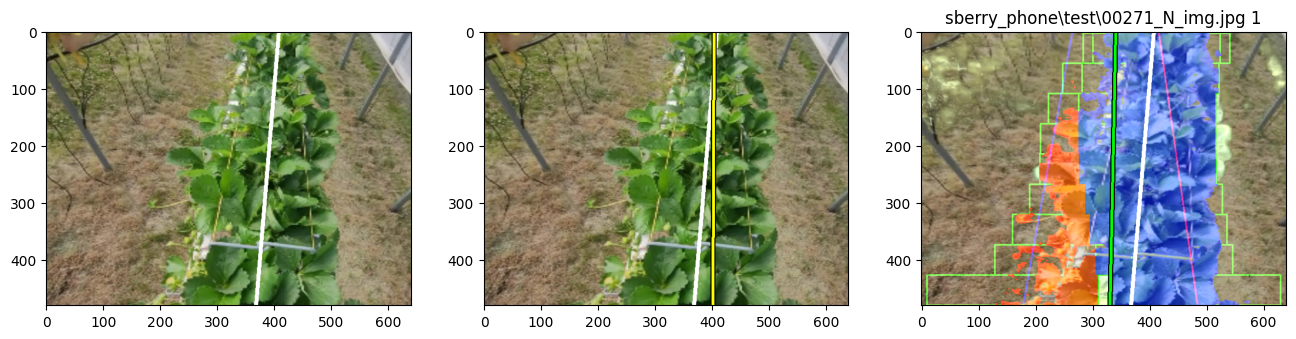

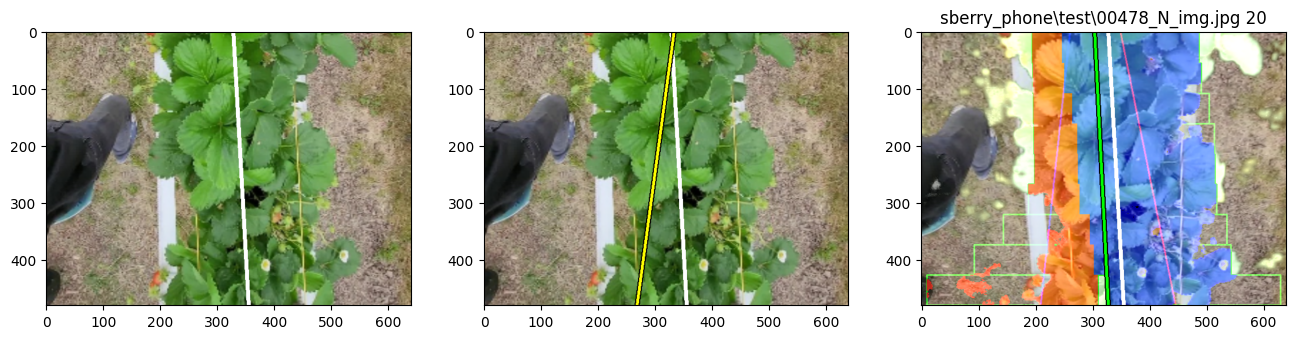

In [24]:
TEST_DIR = "./sberry_phone/test/"
test_images = loadpath_img(TEST_DIR)

if AUX_TASK == True:
    plot_predictions(test_images, colormap, model=model)
else:
    plot_predictions(test_images, colormap, model=evaluate_model, zeromode=False, rate=19)

001 - Time: 098 ms - Er:(002, 007) - SUM: 009 - W error: (0.00096)
016 - Time: 097 ms - Er:(057, 033) - SUM: 090 - W error: (0.05384)

Average Proc time.:  99.7 | IoU:  0.0

Average Error....: 3.12 95% Conf Interval: (1.9, 4.3)

Average W Error..: 0.016356 95% Conf Interval: (0.006723)


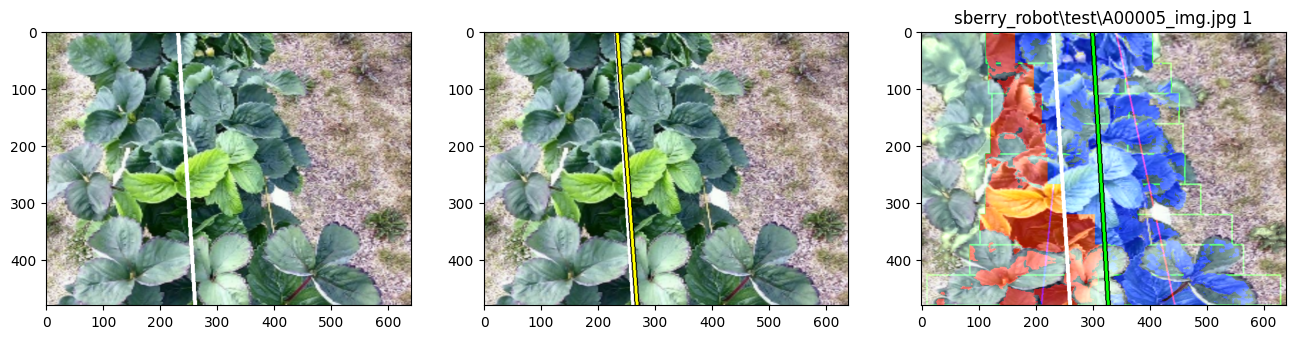

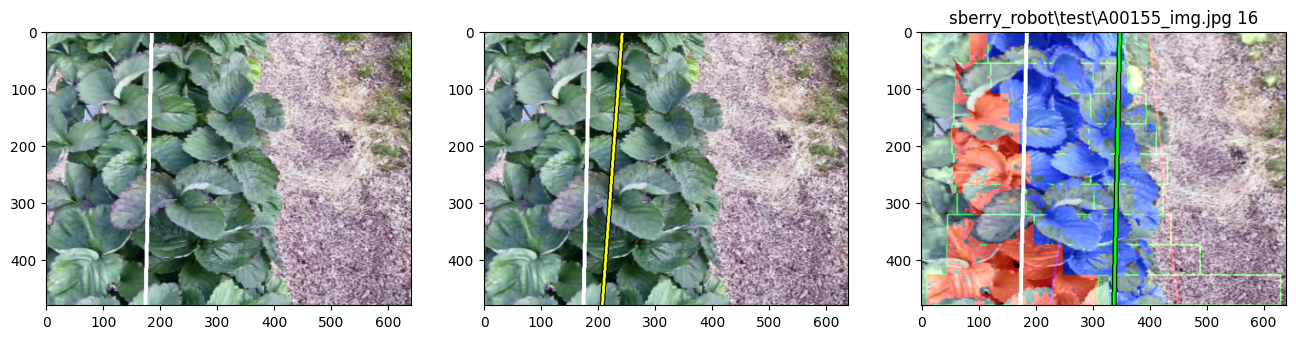

In [25]:
TEST_DIR = "./sberry_robot/test/"
test_images = loadpath_img(TEST_DIR)

if AUX_TASK == True:
    plot_predictions(test_images, colormap, model=model)
else:
    plot_predictions(test_images, colormap, model=evaluate_model, zeromode=False, rate=15)

001 - Time: 095 ms - Er:(013, 016) - SUM: 029 - W error: (0.02507)
016 - Time: 096 ms - Er:(006, 017) - SUM: 023 - W error: (0.00088)

Average Proc time.:  110.45 | IoU:  0.0

Average Error....: 3.59 95% Conf Interval: (2.2, 5.0)

Average W Error..: 0.023913 95% Conf Interval: (0.009613)


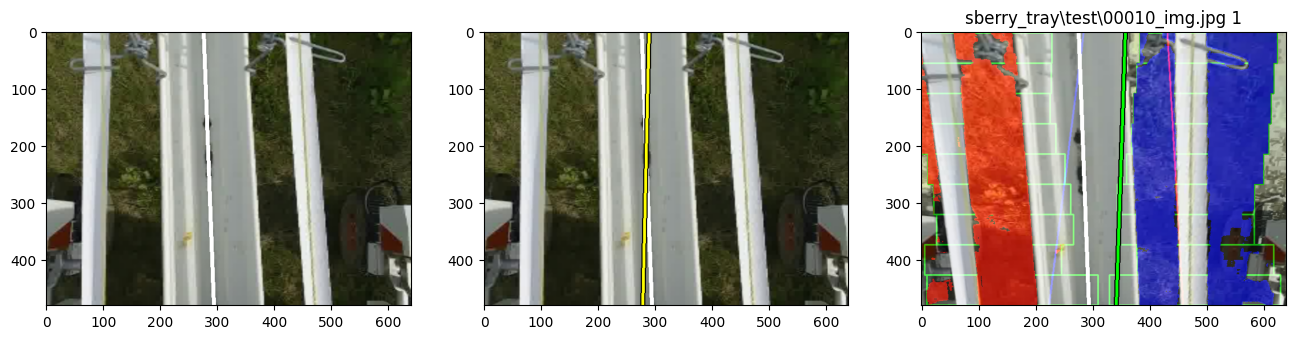

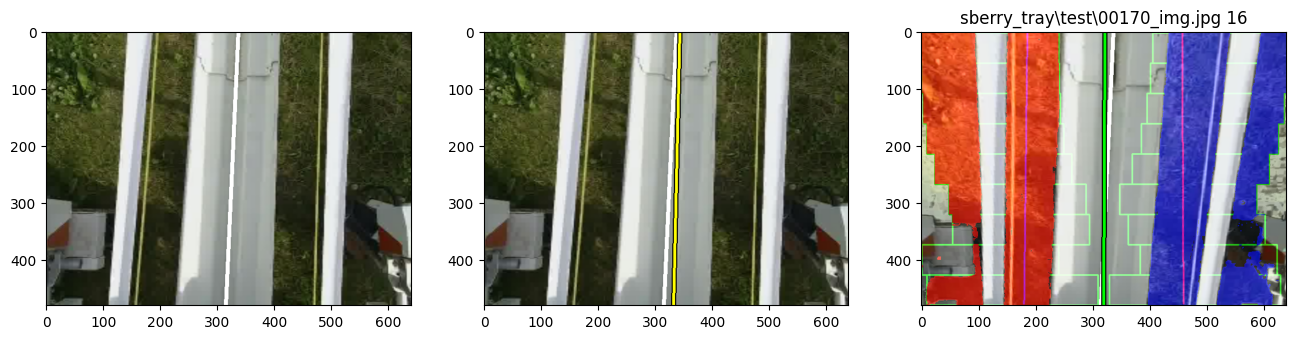

In [26]:
TEST_DIR = "./sberry_tray/test/"
test_images = loadpath_img(TEST_DIR)

if AUX_TASK == True:
    plot_predictions(test_images, colormap, model=model)
else:
    plot_predictions(test_images, colormap, model=evaluate_model, zeromode=False, rate=15)

001 - Time: 101 ms - Er:(013, 016) - SUM: 029 - W error: (0.08610)
026 - Time: 095 ms - Er:(209, 219) - SUM: 428 - W error: (0.14965)
051 - Time: 098 ms - Er:(010, 021) - SUM: 031 - W error: (0.01177)

Average Proc time.:  99.18333333333334 | IoU:  0.0

Average Error....: 6.79 95% Conf Interval: (4.4, 9.1)

Average W Error..: 0.056638 95% Conf Interval: (0.011380)


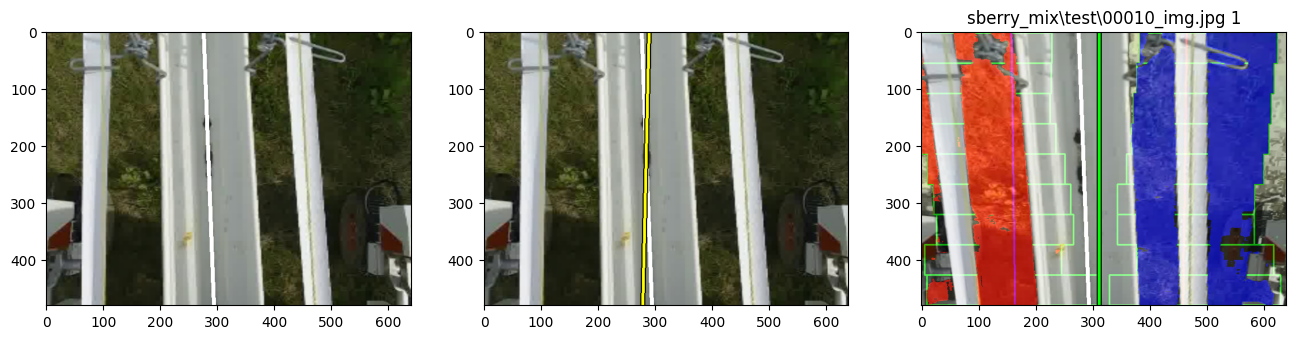

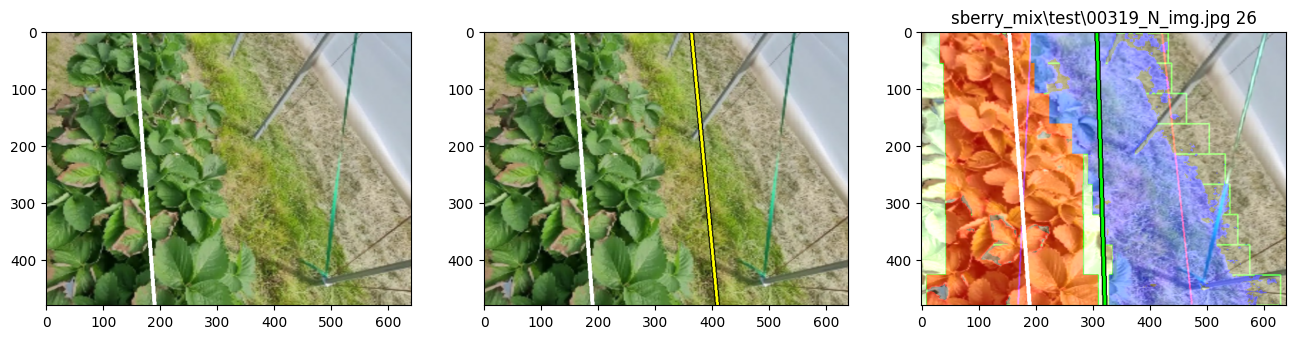

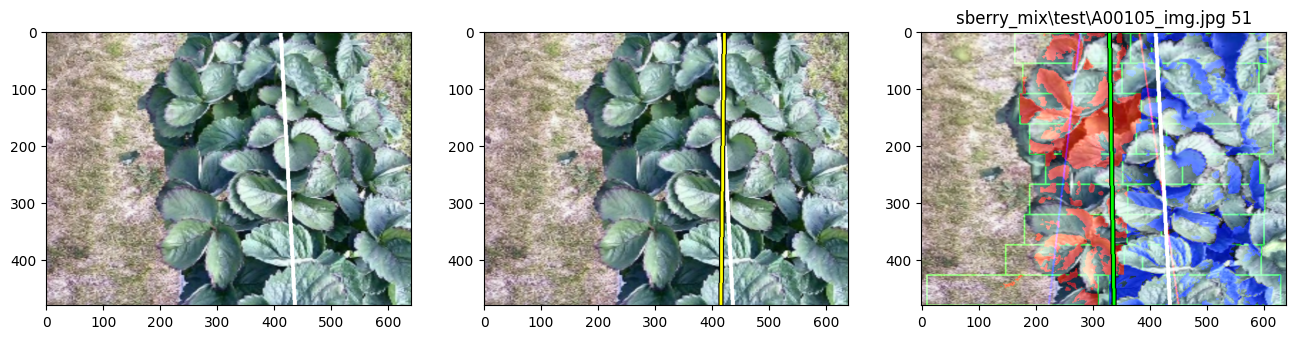

In [27]:
TEST_DIR = "./sberry_mix/test"
test_images = loadpath_img(TEST_DIR)

if AUX_TASK == True:
    plot_predictions(test_images, colormap, model=model)
else:
    plot_predictions(test_images, colormap, model=evaluate_model, zeromode=False, rate=25, camera_mode='bot')